<a href="https://colab.research.google.com/github/Gavriel55555/domain_adaptation/blob/main/DOMAIN_ADAPTATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
from torchvision import datasets, transforms
import os
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
import torch.nn as nn
from torch import optim
from torch.utils.data import random_split ,DataLoader
from torch.autograd import Function

We will use GPU for running time improvement:

In [2]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

cuda


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:

# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the pixel values to range [-1, 1]
])

# Load MNIST train and test datasets
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 64
train_loader_mnist = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 84259604.81it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 14636985.72it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29889366.97it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21821911.53it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



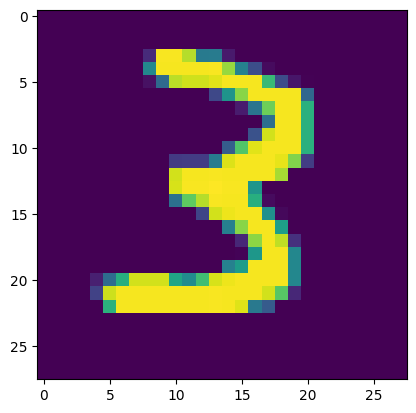

In [33]:
data_iterator = iter(train_loader_mnist)
first_batch = next(data_iterator)
input,label=first_batch
plt.imshow(input[0,0])

# **mnist-m**


We uploaded the data to Google Colab. Then, mounted Google Drive from our Google Colab notebook:

first lets plot the data

In [6]:
pic=os.listdir(('/content/gdrive/My Drive/Colab Notebooks/mnist-m/mnistm/'))

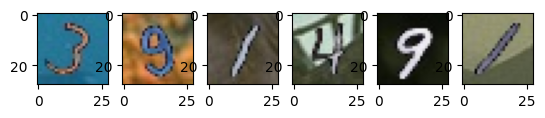

In [7]:
for i in range(6):
  plt.subplot(1,6, i+1)
  image = plt.imread('/content/gdrive/My Drive/Colab Notebooks/mnist-m/mnistm/'+pic[i])
  plt.imshow(image)

lets see the shape of the image

In [8]:
image.shape

(28, 28, 3)

as we can see the image shape is (28,28,3) insted if (3,28,28)

In [11]:
image.shape

(28, 28, 3)

In [9]:

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),       #Fliping the images horizontal
    transforms.ToTensor(),                   #Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize
])
data = ImageFolder('/content/gdrive/My Drive/Colab Notebooks/mnist-m/',
                                  transform = transform_train) #Loading train dataset with trasform



'/content/gdrive/My Drive/Colab Notebooks/mnist-m/mnistm/0.jpg'

In [18]:
train_size = int(0.9 * len(data))
test_size = len(data) - train_size
batch_size=64
# Split the dataset into train and test sets
train_dataset, test_dataset = random_split(data, [train_size, test_size])

# Create DataLoaders for train and test sets
train_loader_mnist_m = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

torch.Size([64, 3, 28, 28]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


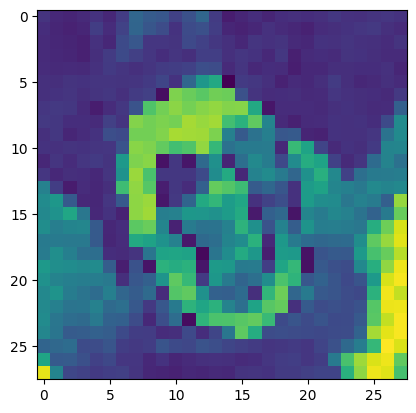

In [75]:
data_iterator = iter(train_loader_mnist_m)
first_batch = next(data_iterator)
input,label=first_batch
print(input.shape,label)
plt.imshow(input[0,0])

torch.Size([64, 1, 28, 28])


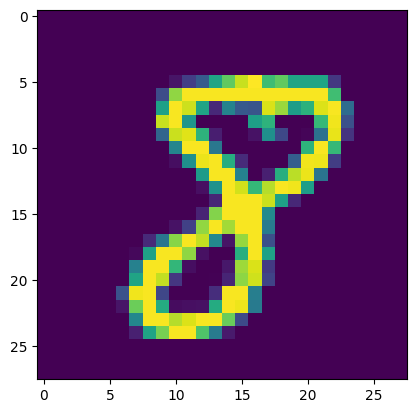

In [21]:
data_iterator = iter(train_loader_mnist)
first_batch = next(data_iterator)
input,label=first_batch
print(input.shape)
plt.imshow(input[0,0])

In [35]:
class GradientReverse(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x

    @staticmethod
    def backward(ctx, grad_output):
        output = -ctx.alpha * grad_output
        return output, None


In [36]:
class NN(nn.Module):
  def __init__(self):
    super(NN,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=30, kernel_size=3, padding=1,stride=1)#((28+2p-f)/s+1=27
    self.bn1 = nn.BatchNorm2d(30)
    self.relu1=nn.ReLU()
    self.max_pool1= nn.MaxPool2d(kernel_size=2, stride=2)#14
    self.conv2 = nn.Conv2d(in_channels=30, out_channels=90, kernel_size=3, padding=1,stride=1)#13
    self.bn2 = nn.BatchNorm2d(90)
    self.relu2=nn.ReLU()
    self.max_pool2= nn.MaxPool2d(kernel_size=2, stride=2)#7

    x=7*7*90
    self.fc1 = nn.Linear(90 * 7 * 7, 128)
    self.relu3 = nn.ReLU()
    self.fc2 = nn.Linear(128, 10)

    #for the domain classifer:
    x=7*7*90
    self.fc3 = nn.Linear(90 * 7 * 7, 128)
    self.relu4 = nn.ReLU()
    self.fc4 = nn.Linear(128, 2)
  def forward(self, x, grl_lambda=1.0):
        x = x.expand(x.data.shape[0], 3, 28, 28)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.max_pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.max_pool2(x)

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)

        # Apply gradient reversal
        feat_domain = GradientReverse.apply(x, grl_lambda)

        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)

        # Domain classifier part
        feat_domain = self.fc3(feat_domain)
        feat_domain = self.relu4(feat_domain)
        feat_domain = self.fc4(feat_domain)

        return x, feat_domain



In [106]:
model=NN()

criterion_label = nn.CrossEntropyLoss()
criterion_domain = nn.CrossEntropyLoss()
lr=0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
num_epoch=6
max_batch=min(len(train_loader_mnist),len(train_loader_mnist_m))

In [107]:
def train_dann(model, source_loader, target_loader, num_epochs, lr):

    for epoch in range(num_epochs):
        for source_data, target_data in zip(source_loader, target_loader):
            # Source data
            source_inputs, source_labels = source_data
            source_domain_labels = torch.zeros(source_inputs.size(0))  # 0 for source domain

            # Target data
            target_inputs, _ = target_data
            target_domain_labels = torch.ones(target_inputs.size(0))  # 1 for target domain

            # Concatenate source and target data
            inputs = torch.cat((source_inputs, target_inputs), dim=0)
            domain_labels = torch.cat((source_domain_labels, target_domain_labels), dim=0)

            # Forward pass
            label_output, domain_output = model(inputs)

            # Calculate losses
            label_loss = criterion_label(label_output[:len(source_inputs)], source_labels)
            domain_loss = criterion_domain(domain_output, domain_labels.unsqueeze(1))

            # Gradient reversal for domain loss
            gradient_reversal = gratiantreverse.apply(domain_output, 1.0)

            # Total loss (trade-off parameter lambda should be adjusted)
            total_loss = label_loss + 0.1 * domain_loss

            # Backpropagation
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

        # Print training loss
        print(f'Epoch [{epoch+1}/{num_epochs}] Total Loss: {total_loss.item():.4f}')

In [108]:
for epoch in range(num_epoch):
  data_iterator_mnist = iter(train_loader_mnist)
  data_iterator_mnist_m = iter(train_loader_mnist_m)
  for batch in range(max_batch):
      optimizer.zero_grad()
      p=float(batch+epoch*max_batch)/num_epoch*max_batch
      if p == 0:
        lamda = 0  # Set lamda to a default value when p is zero
      else:
        lamda = 2. / (1. + np.exp(-10 * p)) - 1
      #print(lamda)
      # source domain train mnist:
      x_s,y_s=next(data_iterator_mnist)
      #x_s, y_s = x_s.to(device), y_s.to(device)
      y_s_domain=torch.zeros(batch_size,dtype=torch.long)
      #print(y_s_domain.shape)

      x_class,y_domain=model(x_s , lamda)
      #print(y_domain)
      loss_label=criterion_label(x_class,y_s)
      loss_domain=criterion_domain(y_domain,y_s_domain)

      #traget train mnist_m
      x_t,_=next(data_iterator_mnist)
      x_t= x_s#.to(device)
      y_t_domain=torch.ones(batch_size,dtype=torch.long)

      _,y_t_domain=model(x_t,lamda)
      #loss_label=criterion_label(x_class,y_s)
      loss_t_domain=criterion_domain(y_t_domain,y_t_domain)

      # optim
      loss_total=loss_t_domain+loss_domain+loss_label
      loss_total.backward()
      optimizer.step()
  print(f'Epoch [{epoch+1}/{num_epoch}] Total Loss: {loss_total.item():.4f}')

Epoch [1/6] Total Loss: -785536.3125
Epoch [2/6] Total Loss: -2713.3975
Epoch [3/6] Total Loss: -2845.7915
Epoch [4/6] Total Loss: -2454.8464
Epoch [5/6] Total Loss: -1310.2075
Epoch [6/6] Total Loss: -1433.1984


In [109]:
#for x,t in test_loader:
val_losses = []
val_accuracies =[]
model.eval()  # Set the model to evaluation mode
val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for val_batch_data, val_batch_targets in test_loader:
        val_outputs, _ = model(val_batch_data, lamda)
        val_loss += criterion_label(val_outputs, val_batch_targets).item()
        _, predicted = torch.max(val_outputs, 1)
        print(val_batch_targets.shape ,predicted)
        total += val_batch_targets.size(0)
        correct += (predicted == val_batch_targets).sum().item()

val_accuracy = 100 * correct / total
val_losses.append(val_loss / len(test_loader))
val_accuracies.append(val_accuracy)

print(f", Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.2f}%")


torch.Size([64]) tensor([2, 2, 6, 2, 2, 2, 2, 5, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 4, 2, 5, 2, 2, 5,
        2, 5, 2, 2, 3, 5, 2, 5, 2, 2, 6, 2, 2, 5, 2, 5, 2, 2, 2, 2, 2, 2, 2, 5,
        5, 2, 2, 5, 2, 2, 4, 2, 5, 2, 2, 2, 5, 2, 5, 2])
torch.Size([64]) tensor([6, 2, 2, 2, 2, 2, 5, 5, 2, 5, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 5, 5, 2,
        2, 2, 2, 2, 2, 2, 5, 5, 2, 2, 2, 2, 2, 5, 2, 2, 2, 5, 2, 2, 5, 2, 6, 5,
        6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 2, 2, 3])
torch.Size([64]) tensor([5, 2, 2, 2, 5, 5, 5, 2, 2, 5, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 6, 5, 2,
        5, 2, 4, 2, 2, 2, 2, 6, 2, 2, 2, 6, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 5, 2, 2, 5, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2])
torch.Size([64]) tensor([2, 2, 2, 2, 2, 5, 5, 5, 2, 2, 5, 2, 4, 2, 2, 5, 2, 2, 2, 2, 2, 4, 2, 2,
        5, 5, 2, 2, 6, 2, 2, 5, 8, 5, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 5, 5, 2, 2,
        2, 2, 5, 2, 2, 5, 0, 5, 5, 2, 2, 2, 5, 2, 2, 8])
torch.Size([64]) tensor([2, 2, 5, 2, 2, 2, 4, 2, 2, 2, 2, 2, 6, 